In [ ]:
import os
import urllib.request
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

import ipywidgets as widgets
from IPython.display import display, clear_output

##  Load Dataset

In [2]:
def load_data():
    filename = "indian_liver_patient.csv"
    if not os.path.exists(filename):
        print("Downloading dataset...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00225/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv"
        urllib.request.urlretrieve(url, filename)
        print("Download complete!")

    df = pd.read_csv(filename, header=None)
    df.columns = [
        "Age", "Gender", "TB", "DB", "Alkphos", "Sgpt", "Sgot",
        "TP", "ALB", "A/G Ratio", "Selector"
    ]
    return df

## Preprocess Dataset

In [3]:
def preprocess_data(df):
    
    df["target"] = df["Selector"].apply(lambda x: 1 if x == 1 else 0)
    df.drop(columns=["Selector"], inplace=True)
    
    le = LabelEncoder()
    df["Gender"] = le.fit_transform(df["Gender"])
    
    X = df.drop(columns=["target"])
    y = df["target"]
    
    # Handle missing values and scale them
    preprocess_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    
    X = preprocess_pipe.fit_transform(X)
    
    # Balance dataset
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    
    return X, y, preprocess_pipe

## Multi-Round Randomized K Search

In [4]:
def random_k_search(X_train, y_train, X_test, y_test, rounds=5, tests_per_round=20):
    best_k = None
    best_acc = 0
    all_k, all_acc = [], []
    
    print(" Running multi-round random K search...\n")
    
    for r in range(1, rounds + 1):
        print(f"Round {r}/{rounds}:")
        tested_k = set()
        for _ in range(tests_per_round):
            k = random.randint(1, 50)
            if k not in tested_k:
                tested_k.add(k)
                model = KNeighborsClassifier(n_neighbors=k)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                all_k.append(k)
                all_acc.append(acc)
                print(f"   K={k:<2} → Accuracy={acc:.3f}")
                if acc > best_acc:
                    best_acc, best_k = acc, k
        print()
    
    print(f" Best K = {best_k} (Accuracy = {best_acc:.3f})")
    
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.scatter(all_k, all_acc, color='royalblue', label='Accuracy per K')
    plt.scatter(best_k, best_acc, color='red', s=100, label=f'Best K = {best_k}')
    plt.title("KNN Accuracy vs Randomly Tested K Values")
    plt.xlabel("K (Number of Neighbors)")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()
    
    return best_k, best_acc

## Build Interactive Prediction UI

In [5]:
def build_ui(knn_model, scaler):
    age_slider = widgets.IntSlider(min=1, max=90, value=40, description="Age:")
    gender_dropdown = widgets.Dropdown(options=["Male", "Female"], description="Gender:")
    tb_slider = widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=1.0, description="TB:")
    db_slider = widgets.FloatSlider(min=0.0, max=5.0, step=0.1, value=0.4, description="DB:")
    alk_slider = widgets.IntSlider(min=50, max=1000, step=10, value=250, description="Alkphos:")
    sgpt_slider = widgets.IntSlider(min=0, max=400, step=5, value=30, description="Sgpt:")
    sgot_slider = widgets.IntSlider(min=0, max=400, step=5, value=35, description="Sgot:")
    tp_slider = widgets.FloatSlider(min=4.0, max=9.0, step=0.1, value=6.5, description="TP:")
    alb_slider = widgets.FloatSlider(min=1.0, max=5.0, step=0.1, value=3.0, description="ALB:")
    agr_slider = widgets.FloatSlider(min=0.0, max=3.0, step=0.1, value=1.0, description="A/G:")

    predict_button = widgets.Button(description="Predict", button_style='info')
    output = widgets.Output()

    def on_predict(_):
     with output:
        clear_output(wait=True)
        try:
            gender_encoded = 1 if gender_dropdown.value == "Male" else 0
            data = [[
                age_slider.value, gender_encoded, tb_slider.value, db_slider.value,
                alk_slider.value, sgpt_slider.value, sgot_slider.value,
                tp_slider.value, alb_slider.value, agr_slider.value
            ]]

            # DataFrame creation
            columns = ["Age", "Gender", "TB", "DB", "Alkphos", "Sgpt", 
                       "Sgot", "TP", "ALB", "A/G Ratio"]
            patient_df = pd.DataFrame(data, columns=columns)

            # Transform using pipeline safely
            data_scaled = scaler.transform(patient_df)
            probs = knn_model.predict_proba(data_scaled)[0]
            pred = np.argmax(probs)
            conf = probs[pred] * 100

            # prediction result
            if pred == 1:
                print(f" The patient MAY HAVE LIVER DISEASE")
            else:
                print(f" The patient is LIKELY HEALTHY")
            print(f"Confidence: {conf:.2f}%\n")

            # Normal ranges
            normal_ranges = {
                "TB": (0.1, 1.2),
                "DB": (0.0, 0.3),
                "Alkphos": (44, 147),
                "Sgpt": (7, 56),
                "Sgot": (8, 48),
                "TP": (6.0, 8.3),
                "ALB": (3.5, 5.0),
                "A/G Ratio": (1.0, 2.5)
            }

            values = {
                "TB": tb_slider.value,
                "DB": db_slider.value,
                "Alkphos": alk_slider.value,
                "Sgpt": sgpt_slider.value,
                "Sgot": sgot_slider.value,
                "TP": tp_slider.value,
                "ALB": alb_slider.value,
                "A/G Ratio": agr_slider.value
            }

            # shows normal and abnormal values
            print(" Parameter Comparison:")
            for param, val in values.items():
                low, high = normal_ranges[param]
                if low <= val <= high:
                    status = " Normal"
                else:
                    status = " Abnormal"
                print(f"{param:<10}: {val:<6} (Normal: {low}–{high}) → {status}")

            # shows if he have liver disease
            labels = ["Healthy", "Liver Disease"]
            plt.close('all')
            fig, ax = plt.subplots(figsize=(8, 3))
            ax.bar(labels, probs * 100, color=["green", "red"])
            ax.set_title("Prediction Confidence (%)")
            ax.set_ylabel("Probability (%)")
            ax.set_ylim(0, 100)
            for i, v in enumerate(probs * 100):
                ax.text(i, v + 2, f"{v:.1f}%", ha="center")
            plt.show()

        except Exception as e:
            print(f" Error: {e}")


    predict_button.on_click(on_predict)

    ui = widgets.VBox([
        widgets.HTML("<h3> Liver Disease Prediction (KNN Model)</h3>"),
        age_slider, gender_dropdown, tb_slider, db_slider, alk_slider,
        sgpt_slider, sgot_slider, tp_slider, alb_slider, agr_slider,
        predict_button, output
    ])
    display(ui)


## Run Full Pipeline

 Running multi-round random K search...

Round 1/5:
   K=39 → Accuracy=0.713
   K=5  → Accuracy=0.766
   K=48 → Accuracy=0.695
   K=13 → Accuracy=0.707
   K=22 → Accuracy=0.713
   K=32 → Accuracy=0.719
   K=23 → Accuracy=0.707
   K=2  → Accuracy=0.766
   K=12 → Accuracy=0.719
   K=20 → Accuracy=0.707
   K=30 → Accuracy=0.689
   K=27 → Accuracy=0.689
   K=28 → Accuracy=0.689
   K=35 → Accuracy=0.719
   K=19 → Accuracy=0.713
   K=37 → Accuracy=0.713
   K=34 → Accuracy=0.719
   K=41 → Accuracy=0.707
   K=38 → Accuracy=0.707

Round 2/5:
   K=16 → Accuracy=0.707
   K=19 → Accuracy=0.713
   K=5  → Accuracy=0.766
   K=47 → Accuracy=0.701
   K=36 → Accuracy=0.725
   K=44 → Accuracy=0.719
   K=30 → Accuracy=0.689
   K=49 → Accuracy=0.707
   K=4  → Accuracy=0.749
   K=45 → Accuracy=0.719
   K=50 → Accuracy=0.701
   K=18 → Accuracy=0.719
   K=7  → Accuracy=0.725
   K=12 → Accuracy=0.719
   K=11 → Accuracy=0.689
   K=33 → Accuracy=0.707

Round 3/5:
   K=7  → Accuracy=0.725
   K=34 → Accuracy=0.719

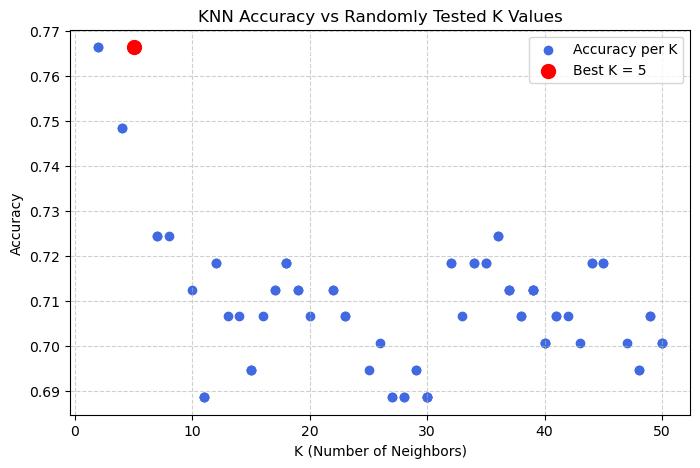


 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.89      0.81        92
           1       0.82      0.61      0.70        75

    accuracy                           0.77       167
   macro avg       0.78      0.75      0.76       167
weighted avg       0.78      0.77      0.76       167



In [ ]:
df = load_data()
X, y, scaler = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_k, best_acc = random_k_search(X_train, y_train, X_test, y_test)

final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

y_pred = final_knn.predict(X_test)
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# widget interface
build_ui(final_knn, scaler)